# Example notebook for using the MCMC

This notebook shows an example of how to use the classes from the MCMCs file.

## 0. Import everything needed

In [24]:
import numpy as np
import random
import matplotlib.pyplot as plt

The classes needed are `Neal_3` and `PPMx` located in main_code.MCMCs.

The `generate_gaussian_mixture` function will create the synthetic data for our example.

`plot_clusters` is used for visualizations.

In [25]:
import sys, os
sys.path.insert(0, os.path.dirname(os.path.abspath('../../main_code')))
from main_code.MCMCs import Neal_3, PPMx
from main_code.data_generation import generate_gaussian_mixture
from main_code.visualization import plot_clusters

## 1. Generate data


For this example, we generate 3 clusters of 50 elements each, we also set the covariates to be gaussian distributed.


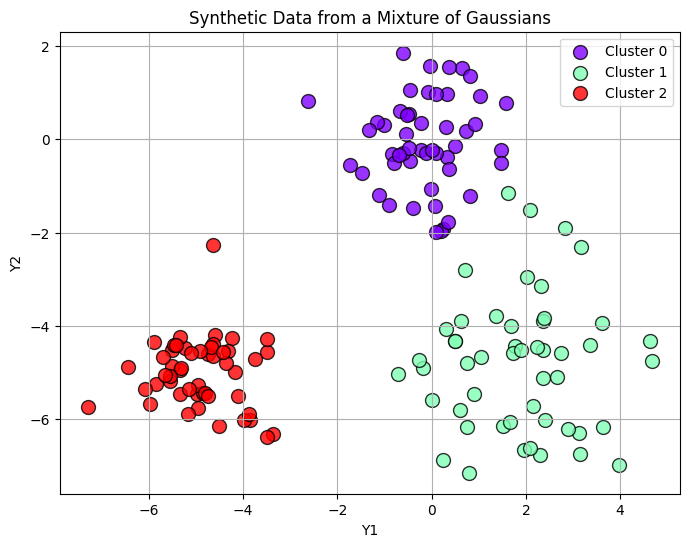

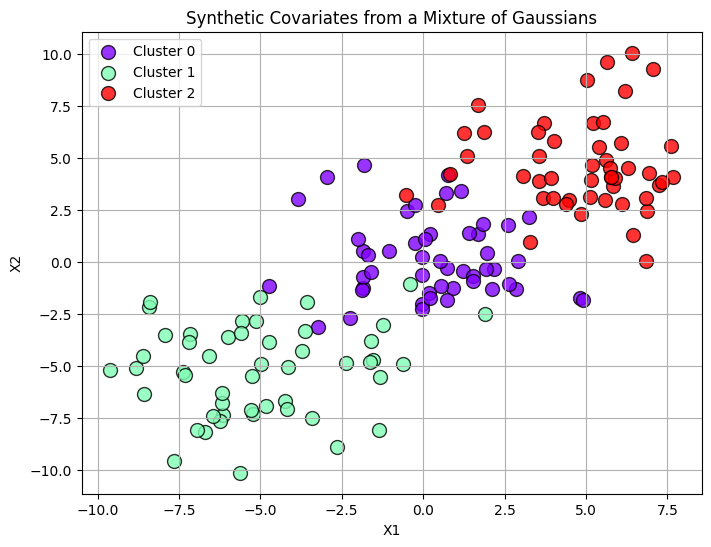

In [26]:
# Sample syntethic
np.random.seed(42)  # for reproducibility
random.seed(42)

# Y
means = [[0, 0], [2, -5], [-5, -5]]
covariances = [np.eye(2), 2 * np.eye(2), 0.5 * np.eye(2)]
n_samples = [50, 50, 50]

Y, labels = generate_gaussian_mixture(means, covariances, n_samples)

plot_clusters(Y, labels, "Synthetic Data from a Mixture of Gaussians", xlabel="Y1", ylabel="Y2")


# X
means_X = [[0, 0], [-5, -5], [5, 5]]
covariances_X = [np.eye(2)*5, np.eye(2)*5, np.eye(2)*5]

X, _ = generate_gaussian_mixture(means_X, covariances_X, n_samples)

plot_clusters(X, labels, "Synthetic Covariates from a Mixture of Gaussians")

## 2. Neal Algorithm 3 (without covariates)

### 2.1 Create the object

We try to cluster the data using only the Y data.

First step is to create a `Neal_3` object. By default the hyper-parameters $\alpha $ and $\lambda_0$ are set to `alpha=0.1` and `lamb_0=1` but they can be given as arguments when creating the object. Other hyper-parameters needs to be changed in the file or manually after creating the object.

In [27]:
alpha = 0.1

neal_3 = Neal_3(alpha=alpha)

We also define some more variable necessary for the code to work

In [28]:
iter = 100
burn_in = 20
iterations = list(range(iter + 1))

### 2.2 Fit it to data

Then we can fit the object to the data. That is, we apply neal algorithm 3 with our data. To do so, we call the `.fit()` method. The method must take the data `Y` and the number of step to do as arguments. 

It can also take `metrics` as argument. `metrics` must be a list of the containing the names of the metrics to compute while performing the MCMC (to later create trace plots). For now the only metric implemented in `"entropy"` but others might be added later.


Here we will just run this example for 100 iterations

In [29]:
history = neal_3.fit(Y, 100, metrics=["entropy"])

MCMC Progress:   0%|          | 0/100 [00:00<?, ?step/s]

MCMC Progress: 100%|██████████| 100/100 [00:41<00:00,  2.42step/s]


`fit()` will output the history but it is also stored in the object at `neal_3.history`

### 2.3 Visualize the results

Here you can see how an element of the `history` can be accessed.

Here we access the last element and plot what is inside it.

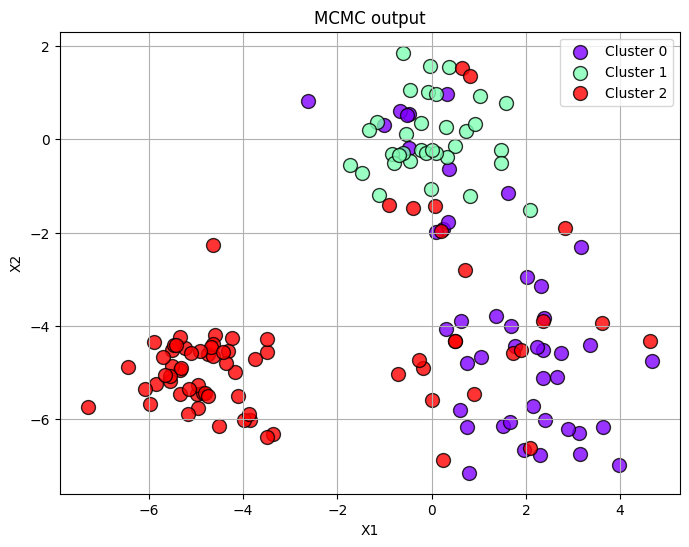

Similarity Matrix Progress: 100%|██████████| 81/81 [00:00<00:00, 322.21step/s]


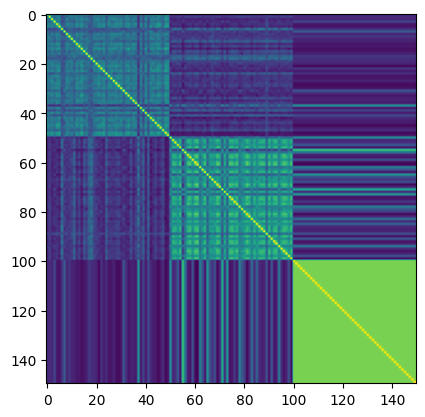

In [30]:
plot_clusters(Y, neal_3.history[-1], "MCMC output")
plt.show()
neal_3.compute_similarity_matrix(burn_in)
plt.imshow(neal_3.similatity_matrix)
plt.show()

Another thing we can plot and inspect is the traceplot.

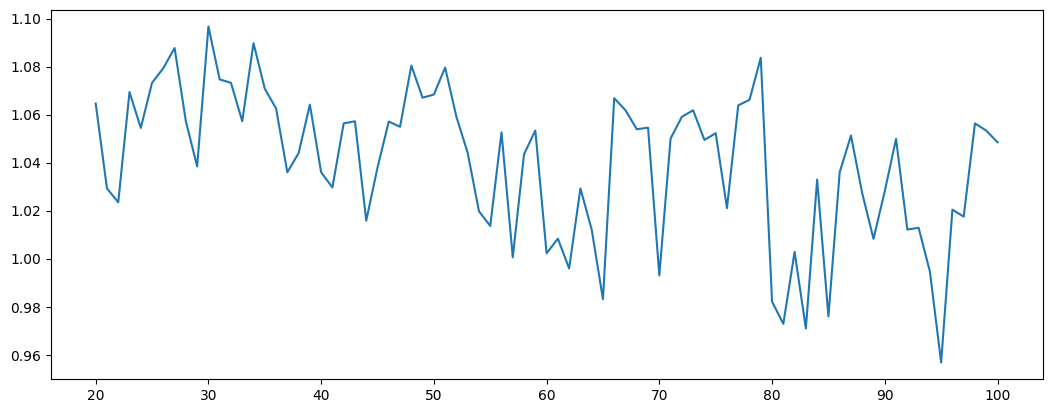

In [31]:
plt.figure(figsize=(12.8, 4.8))
plt.plot(iterations[burn_in:], neal_3.metrics["entropy"][burn_in:])
plt.show()

Finally we can access the point estimate made using the `history` via minimization of the Binder loss.

The value of the optimal loss is stored in `neal_3.optimal_loss`.

Point Estimate Progress: 100%|██████████| 101/101 [00:03<00:00, 28.81step/s]


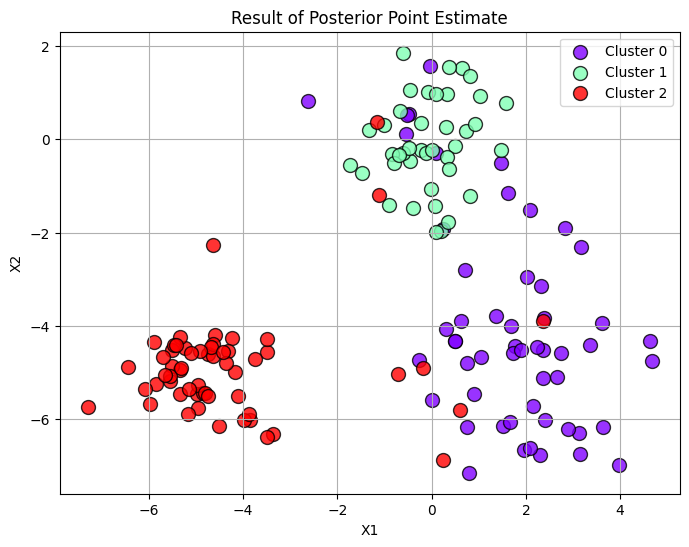

In [32]:
_, _ = neal_3.find_optimal_clustering()
plot_clusters(Y, neal_3.optimal_clustering, "Result of Posterior Point Estimate")

### 2.4 Save object to file

After fitting the object, you may want to save it to a file to process/analyse the results later. To save the object, use the `.save(filepath)` method. Any attribute of the object will be saved to this file.

Note that if you have already made some analysis of the result (namely similarity matrix and posterior point estimate) their value will also be saved.

In [33]:
file_path = "../../results/test_save.mcmc"
neal_3.save(file_path)

del neal_3

### 2.5 Load object from file

To load the object from a file, use the class method `Neal_3.load(file_path)`. You can then use the object normally.

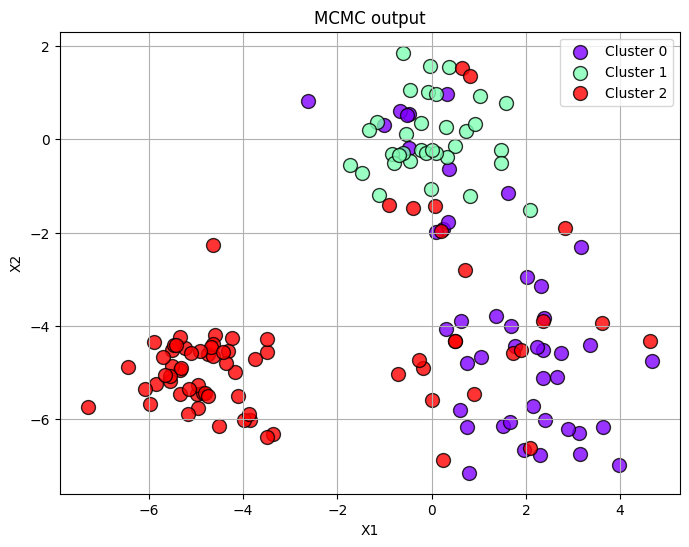

In [34]:
file_path = "../../results/test_save.mcmc"
neal_3_loaded = Neal_3.load(file_path)

# Example to show that the computed clustering is still accessible
plot_clusters(Y, neal_3_loaded.history[-1], "MCMC output")
plt.show()

## 3. PPMx : include covariates

### 3.1 Create the object

Create the object the same way as before.

In [35]:
alpha = 0.1

ppmx = PPMx(alpha = alpha)

iter = 100
burn_in = 20
iterations = list(range(iter + 1))

### 3.2 Fit to data

Now we have covariates so the `fit()` function takes `Y`, `X` and the number of steps as arguments. You can also specify `lambda_penalty` to control the covariate penalty. default is `lambda_penalty=0.1`.

In [36]:
lambda_pen = 0.1

history = ppmx.fit(Y, X, 100, metrics=["entropy"], lambda_penalty=lambda_pen)

MCMC Progress:   0%|          | 0/100 [00:00<?, ?step/s]

MCMC Progress: 100%|██████████| 100/100 [01:15<00:00,  1.33step/s]


### 3.3 Visualize results

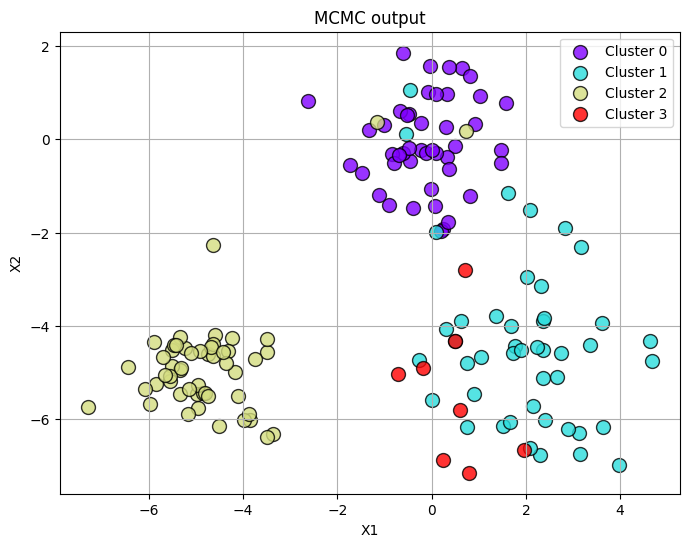

Similarity Matrix Progress: 100%|██████████| 81/81 [00:00<00:00, 302.43step/s]


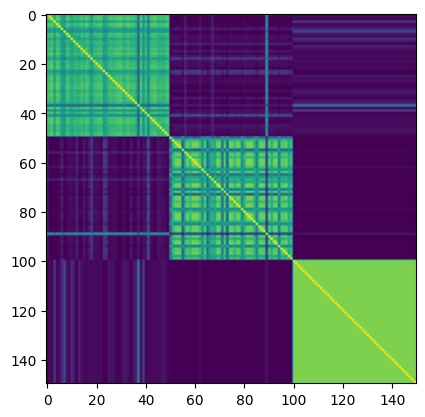

In [37]:
plot_clusters(Y, ppmx.history[-1], "MCMC output")
plt.show()
ppmx.compute_similarity_matrix(burn_in)
plt.imshow(ppmx.similatity_matrix)
plt.show()

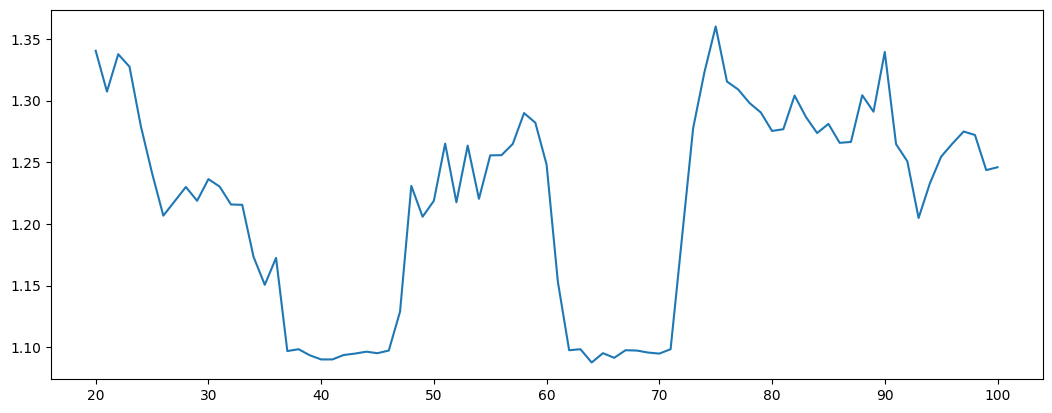

In [38]:
plt.figure(figsize=(12.8, 4.8))
plt.plot(iterations[burn_in:], ppmx.metrics["entropy"][burn_in:])
plt.show()

Point Estimate Progress:   0%|          | 0/101 [00:00<?, ?step/s]

Point Estimate Progress: 100%|██████████| 101/101 [00:04<00:00, 21.11step/s]


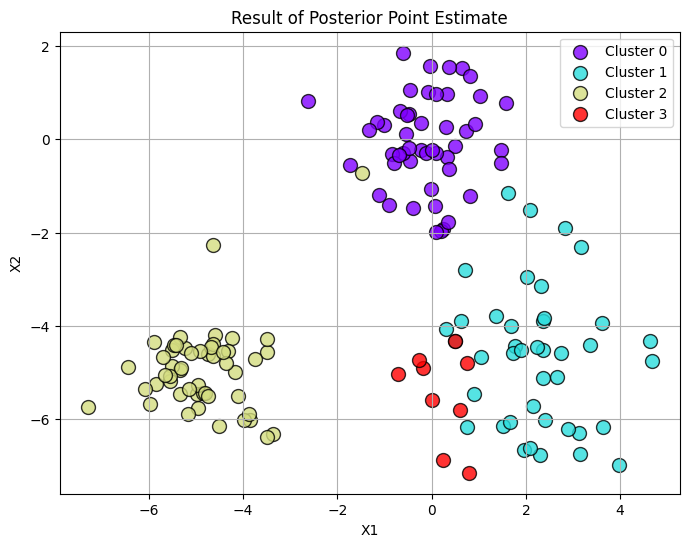

In [39]:
_, _ = ppmx.find_optimal_clustering()
plot_clusters(Y, ppmx.optimal_clustering, "Result of Posterior Point Estimate")

### Save / Load results

You can save and load results in the same way as without covariates with the `.save()` and `.load()` methods.

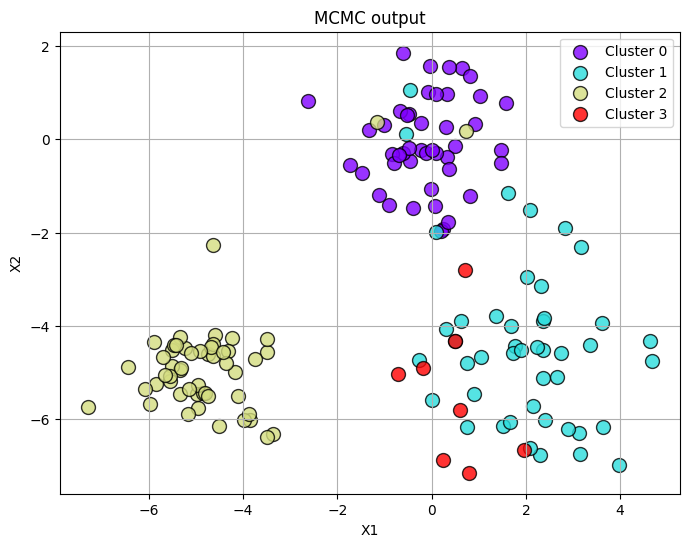

In [40]:
file_path = "../../results/test_with_covariates_save.mcmc"
ppmx.save(file_path)

del ppmx

ppmx_loaded = PPMx.load(file_path)

# Example to show that the computed clustering is still accessible
plot_clusters(Y, ppmx_loaded.history[-1], "MCMC output")
plt.show()